# Notebook 2 — Avançado (RandomizedSearchCV + MLP, foco em Recall)

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

np.random.seed(42); tf.random.set_seed(42)
CSV_PATH = None
target_col = 'diagnosis'


In [2]:

from sklearn.datasets import load_breast_cancer
if CSV_PATH is None:
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='target')
else:
    df = pd.read_csv(CSV_PATH)
    y = df[target_col].astype('category').cat.codes
    X = df.drop(columns=[target_col])

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', num_pipe, num_cols),
                         ('cat', cat_pipe, cat_cols)])

selector = SelectKBest(score_func=f_classif, k=min(20, (len(num_cols)+len(cat_cols))))
X_proc = pre.fit_transform(X)
X_sel = selector.fit_transform(X_proc, y)

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)


In [4]:

def build_mlp(layers=2, neurons=32, activation='relu', learning_rate=1e-3, dropout=0.0, input_dim=None):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(input_dim,)))
    for _ in range(layers-1):
        model.add(Dense(neurons, activation=activation))
        if dropout>0: model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='recall')])
    return model

mlp = KerasClassifier(model=build_mlp, input_dim=X_train.shape[1], verbose=0)

param_dist = {
    'model__layers': [1, 2, 3],
    'model__neurons': [16, 32, 64],
    'model__activation': ['relu', 'tanh'],
    'model__learning_rate': [1e-3, 1e-2],
    'model__dropout': [0.0, 0.3],
    'batch_size': [16, 32],      # parâmetros de treino do KerasClassifier
    'epochs': [40, 80]           # parâmetros de treino do KerasClassifier
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    refit=True
)

search.fit(X_train, y_train)
print("Melhores parâmetros:", search.best_params_)
print("Melhor recall (val. cruzada):", search.best_score_)

c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Melhores parâmetros: {'model__neurons': 16, 'model__learning_rate': 0.01, 'model__layers': 3, 'model__dropout': 0.3, 'model__activation': 'relu', 'epochs': 40, 'batch_size': 16}
Melhor recall (val. cruzada): 0.9964912280701753


Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.3547 - recall: 0.9397 - val_loss: 0.0677 - val_recall: 0.9623
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1226 - recall: 0.9741 - val_loss: 0.0373 - val_recall: 1.0000
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0687 - recall: 0.9914 - val_loss: 0.0243 - val_recall: 1.0000
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0860 - recall: 0.9914 - val_loss: 0.0279 - val_recall: 1.0000
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0471 - recall: 0.9914 - val_loss: 0.0335 - val_recall: 1.0000
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0774 - recall: 0.9871 - val_loss: 0.0285 - val_recall: 1.0000
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0666 - recall: 0.9957 - val_loss: 0.0319 - val_recall: 1.0000
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0398 - recall: 1.0000 - val_loss: 0.0222 - val_recall: 1.0000
Epoch 9/40
23/23 ━━━━━

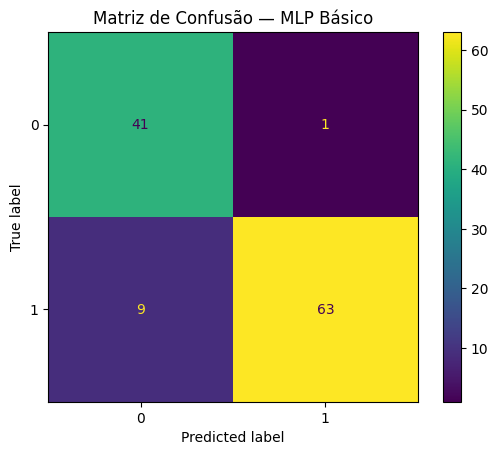

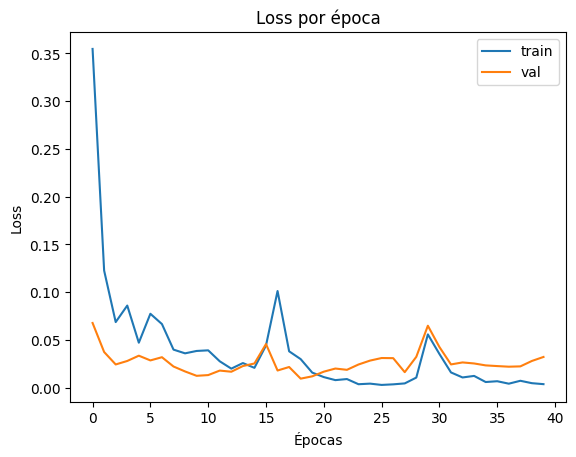

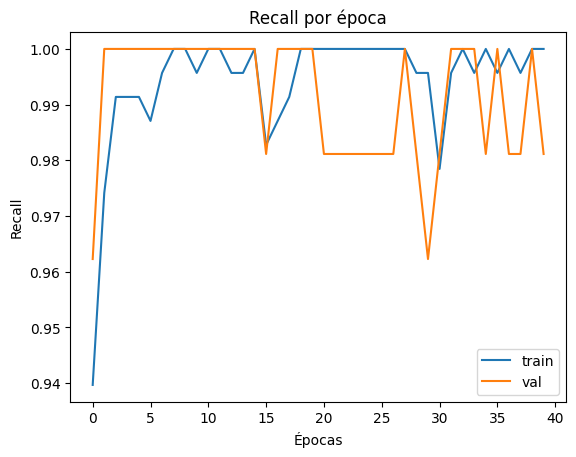

In [7]:
# Extrair melhores parâmetros (removendo prefixo model__)
best_params = {k.replace('model__',''): v for k,v in search.best_params_.items()}

# Criar modelo novamente com os melhores parâmetros
best_model = build_mlp(
    layers=best_params.get('layers', 2),
    neurons=best_params.get('neurons', 32),
    activation=best_params.get('activation', 'relu'),
    learning_rate=best_params.get('learning_rate', 1e-3),
    dropout=best_params.get('dropout', 0.0),
    input_dim=X_train.shape[1]
)

# Treinar manualmente para capturar o histórico
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_params.get('epochs', 40),
    batch_size=best_params.get('batch_size', 32)
)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusão — MLP Básico")
plt.show()

# Agora podemos plotar Loss e Recall
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.legend()
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
plt.xlabel("Épocas")
plt.ylabel("Recall")
plt.title("Recall por época")
plt.legend()
plt.show()

